In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# %load https://gist.githubusercontent.com/fontclos/a398c95d2841dfb19e864d08c1f60201/raw/fd3d86c9836be250ed34be6ec87c9c7dc43b9d4a/matplotlib_defaults.py
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [3]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.
    
    All elements are [-1, 1] with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config = np.random.randint(2, size=(N,N))
    for i in range(N):
        for j in range(N):
            if(config[i,j]==0):config[i,j]=-1
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [4]:
config = create_initial_config(N=100)
print(config)

[[ 1  1  1 ... -1 -1 -1]
 [ 1  1 -1 ... -1  1 -1]
 [-1  1  1 ...  1 -1  1]
 ...
 [ 1  1 -1 ... -1  1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1 -1 ...  1 -1 -1]]


To plot our system we can use `plt.imshow()`, as follows:

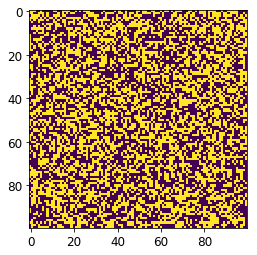

In [5]:
plt.imshow(config);

### Exercise 
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

<div class="alert alert-block alert-danger">
**{Answer} Recalling the Ising Hamiltonian -->INSERT HERE
the change in energy associated with the examined transformation is $2*sum(s_j)$ over primim vicini**
</div>

### Exercise
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, you can use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [6]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N==M
    
    # choose random site
    i = np.random.randint(N)
    j = np.random.randint(N)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 0
    DeltaE = config[i, j-1] + config[i-1, j]
    if(j==N-1):DeltaE += config[i, 0]
    else: DeltaE += config[i, j+1]
    if(i==N-1):DeltaE += config[0, j]
    else: DeltaE += config[i+1, j]
    DeltaE = 2*DeltaE*s
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the spin
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        if (np.random.rand()<np.exp(-(1/T)*DeltaE)):
            # flip the spin
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
Try executing the cell below at different values of the temperature, for different system size. 

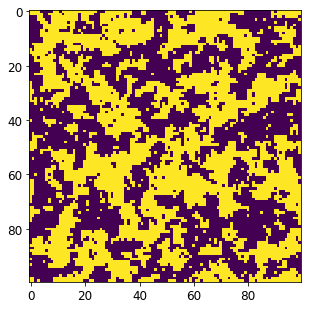

In [7]:
T_c = 2/np.log(1+np.sqrt(2))
#T_c=0.00001

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [8]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i0, j0, i1, j1) represents two adjacent sites located
    # at (0, j0) and (i1, j1)
    horizontal_edges = [
        (i, j-1, i, j)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i-1, j, i, j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    
    return E #there is a 2*E here

In [9]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    
    config = create_initial_config(N)
    energy = get_energy(config)
    Es = np.array(energy)
    #np.append(Es,energy)
    for t in range(n_updates):
        energy += metropolis_single_update(config,T)
        #print(energy)
        Es = np.append(Es,energy)
    
    return Es

### Exercise
Compute the energy of your system during a long simulation, and plot it as a function of time.
Can you distinguish two qualitatively different periods? What do they correspond to?

In [10]:
energy_evolution = get_energy_evolution(20, T_c, 50000)
print(energy_evolution)

[   0    0   -4 ... -472 -468 -468]


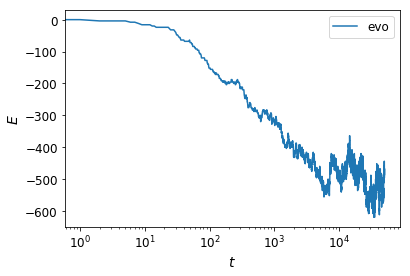

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.semilogx(energy_evolution, label="evo")

ax.set_xlabel("$t$")
ax.set_ylabel("$E$")
ax.legend()

<div class="alert alert-block alert-danger">
**ANSWER**

</div>

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [12]:
import sys
sys.path.append("SethnasBookCode/")
from Ising import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [13]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [14]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

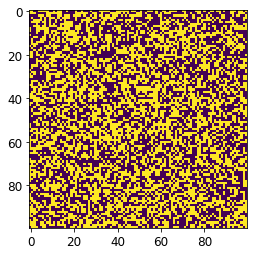

In [15]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [16]:
ising.SweepMetropolis(nTimes=100)

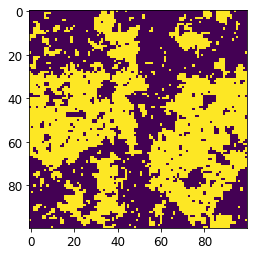

In [17]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [18]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

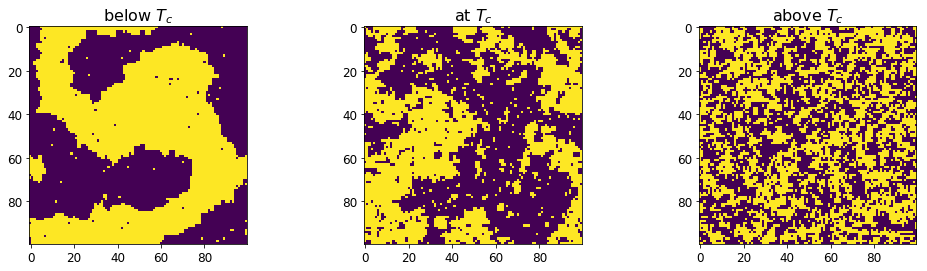

In [19]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute:

In [20]:
%%timeit
# your Ising implementation running for some number of updates
N = 300
config = create_initial_config(N)
for t in range (N*N) :
    E = metropolis_single_update(config, 2/np.log(1+np.sqrt(2)))

1.39 s ± 4.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
N = 300
m_ising = IsingModel(N)
m_ising.SweepMetropolis(nTimes=1)

476 ms ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


My code: 1.47 s ± 65.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) <br>
Sethna's:487 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Sethna's code is almost $2.5$ times faster than mine.

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [22]:
# set system size, temperature
system_size = 100 

#temperature = 0.5
#temperature = T_c
#temperature = 5
temperature = 10
#temperature = 100

steps_num = 500
graph_check_y = np.zeros(steps_num)
# run some Wolff sweeps, check if equilibrium
m_ising = IsingModel(system_size, temperature)
for i in range(steps_num):
    m_ising.SweepWolff()
    graph_check_y[i] = np.mean(m_ising.lattice)

In [23]:
absc = np.zeros(steps_num)
theoretical_graph = np.zeros(steps_num)
for i in range (steps_num):
    absc[i]=i
    theoretical_graph[i] = 0.5

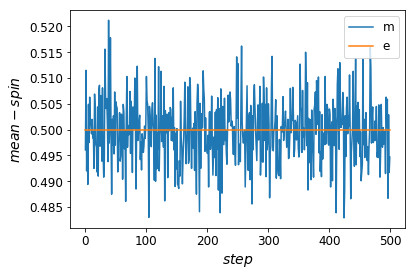

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(absc, graph_check_y, label="Wolff_equilibrium")
ax.plot(absc, theoretical_graph, label="teorethical_equilibrium")
ax.set_xlabel("$step$")
ax.set_ylabel("$mean-spin$")
ax.legend("mean")

<div class="alert alert-block alert-danger">
Answer:

To check if the system is in equilibrium we take a mean of all the values in the lattice; as the mean approaches the value $0.5$ the system can be considered in equilibrium. The equilibrium condition depends on the temperature of the system. We notice that at temperature higher than the critial point equilibrium is easy to be attained and the empirical mean value is always close to the theoretical one. At the critical temperature the system "oscillates" irregularly around the mean value. For even lower temperatures the system is magnetized and as the Wolff algorithm makes the system evolve the mean value gets to 1 after very few steps.
</div>

### Exercise
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [25]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    m_ising = IsingModel(system_size, temperature)
    # equilibrate
    m_ising.SweepWolff(equilibration_time)
    # compute magnetization
    m = np.mean(m_ising.lattice*2-1) #renormalition centered in zero
    return m


### Exercise
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [26]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=100)
# system size
system_size = 64
# equilibration time
equilibration_time = 100

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size, temperature, equilibration_time)
    magnetizations.append(magnetization)

Text(0, 0.5, '$M$')

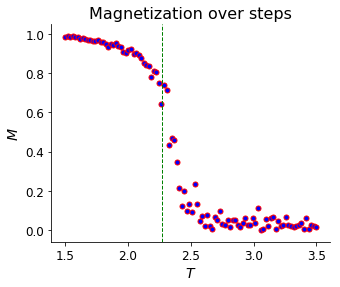

In [27]:
# define critical temperature
T_c = 2/np.log(1+np.sqrt(2))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, np.abs(magnetizations),
    # style keywords
    edgecolors="red", color="blue", s=25
)
ax.axvline(
    T_c,
    # style keywords
    c="green", lw=1, ls = "dashed"
)
ax.set_title("Magnetization over steps")
ax.set_xlabel("$T$")
ax.set_ylabel("$M$")

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

<div class="alert alert-block alert-danger">
Answer:

By definition, susceptibility plays for magnetism an analougus role of specific heat with energy. So in the case of magnetization, in the canonical ensemble at themperature $T$, with an analogous procedure we get:
$$
\chi = \frac{1}{T} \left\langle (M - \langle M \rangle)^2 \right\rangle
$$
</div>

### Exercise
Write a function that computes the energy of an Ising configuration

In [28]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    horizontal_edges = [
        (i, j-1, i, j)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i-1, j, i, j)
        for i in range(N) for j in range(N)
    ]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]

    return E / N**2

### Exercise
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [29]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initiate model
    m_ising = IsingModel(system_size, temperature)
    # thermalize (hopefully!)
    m_ising.SweepWolff(equilibration_time)
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for k in range(n_samples):
        # change from 0,1 to -1,1 notation
        config = m_ising.lattice*2-1
        # get magnetization
        m = np.abs(config.mean())
        ms.append(m); m2s.append(m**2)
        # get energy
        e = compute_energy(m_ising)
        es.append(e); e2s.append(e**2)
        # update system
        m_ising.SweepWolff()
    
    # compute susceptibility and specific heat
    susceptibility = 1/temperature*(np.mean(m2s)-np.mean(ms)**2)
    specific_heat = 1/temperature**2*(np.mean(e2s)-np.mean(es)**2)
    
    return susceptibility, specific_heat



### Exercise
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [30]:
# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 3.5, num=50)
# system size
system_size = 25
# equilibration time
equilibration_time = 100
# n_samples
n_samples = 25

# loop over temperatures, compute susceptibility and specific_heat
susceptibilities = []
specific_heats = []
for temperature in temperatures:
    susceptibility, specific_heat = calculate_susceptibility_specific_heat(system_size, temperature, 
                                                                           equilibration_time, n_samples)
    susceptibilities.append(susceptibility)
    specific_heats.append(specific_heat)


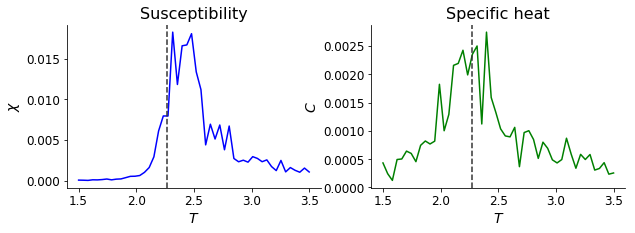

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax=ax1
ax.plot(temperatures, susceptibilities, color="blue")
ax.axvline(T_c, color="0.2", ls="dashed")
ax.set_ylabel("$\chi$")
ax.set_xlabel("$T$")
ax.set_title("Susceptibility")

ax=ax2
ax.plot(temperatures, specific_heats, color="green")
ax.axvline(T_c, color="0.2", ls="dashed")
ax.set_ylabel("$C$")
ax.set_xlabel("$T$")
ax.set_title("Specific heat");


### Exercise
Discuss whether or not your results proof the existence of a phase transition.

<div class="alert alert-block alert-danger">
**ANSWER**
</div>